In [29]:
%cd /content/drive/MyDrive/Colab\ Notebooks/입찰/LSTM

/content/drive/MyDrive/Colab Notebooks/입찰/LSTM


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras import optimizers

In [31]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test

In [32]:
def datamake(data):
  ndata = []
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    temp = sum / 2
    temp += np.random.rand(1) / 100
    ndata.append(temp)
  ndata.append(data[-1])
  ndata = np.array(ndata) # train_added
  return ndata

In [33]:
train_added = datamake(train_raw)
test_added = datamake(test_raw)

In [34]:
sc1 = MinMaxScaler()
train_added_scaled = sc1.fit_transform(train_added) # train_added_scaled
test_added_scaled = sc1.fit_transform(test_added) # test_scaled
print(train_added_scaled.shape)
print(test_added_scaled.shape)

(4885, 1)
(543, 1)


In [35]:
length = 3
seq_length = length * 2

In [36]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]+1, 2):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [37]:
X_train, Y_train = make_data(train_added_scaled) # train_added_scaled
X_test, Y_test = make_data(test_added_scaled) # test_added_scaled

In [38]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

concat = concatenate([x, y])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
output = Dense(1)(output)
model = Model(inputs = inputs, outputs = output)

#model.summary()

In [39]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, Y_train, epochs = 50, batch_size = 10, validation_split=0.1)

Epoch 1/50
220/220 [==============================] - 9s 16ms/step - loss: 0.0392 - val_loss: 0.0360
Epoch 2/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0334 - val_loss: 0.0316
Epoch 3/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0331 - val_loss: 0.0308
Epoch 4/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0332 - val_loss: 0.0311
Epoch 5/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0328 - val_loss: 0.0312
Epoch 6/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0320 - val_loss: 0.0326
Epoch 7/50
220/220 [==============================] - 2s 9ms/step - loss: 0.0315 - val_loss: 0.0297
Epoch 8/50
220/220 [==============================] - 2s 9ms/step - loss: 0.0297 - val_loss: 0.0251
Epoch 9/50
220/220 [==============================] - 2s 10ms/step - loss: 0.0163 - val_loss: 0.0033
Epoch 10/50
220/220 [==============================] - 2s 9ms/step - loss: 0.0056 - val_loss:

In [40]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)

mean_train_error = np.average(np.abs(train_raw[length:] - predicted_X_train))

print("평균 training error:", mean_train_error)

평균 training error: 0.11258916148836637


In [41]:
predicted_X_test = model.predict(X_test)
predicted_X_test = sc1.inverse_transform(predicted_X_test)

mean_train_error = np.average(np.abs(test_raw[length:,:] - predicted_X_test))

print("평균 test error:", mean_train_error)

평균 test error: 0.020923531857412307


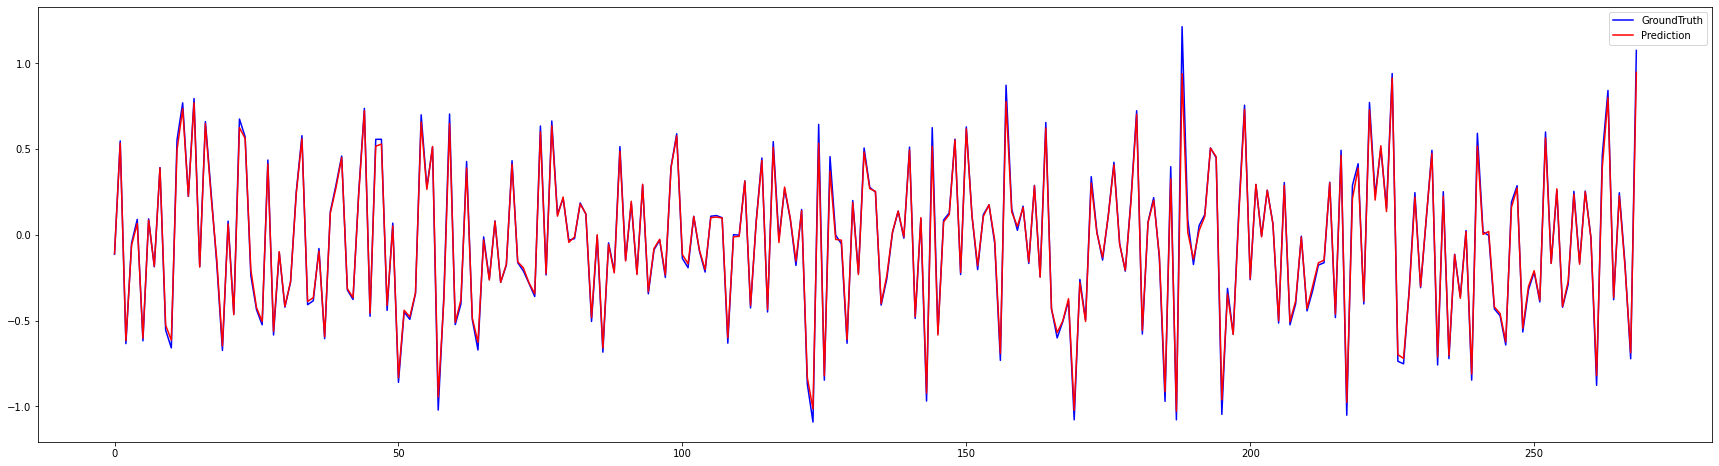

In [42]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test_raw[length:,:], color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_test, color = 'red', label = 'Prediction')
plt.legend()
plt.show()